##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this Colab you will classify images of flowers. You will build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.


# Importing Packages

Let's start by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot the graph and display images in our training and validation data.

In [2]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

### TODO: Import TensorFlow and Keras Layers

In the cell below, import Tensorflow as `tf` and the Keras layers and models you will use to build your CNN. Also, import the `ImageDataGenerator` from Keras so that you can perform image augmentation.

In [3]:
#import packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

After downloading the dataset, we need to extract its contents.

In [4]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

The dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, let's create the labels for these 5 classes: 

In [5]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Also, the dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

As you can see there are no folders containing training and validation data. Therefore, we will have to create our own training and validation set. Let's write some code that will do this.


The code below creates a `train` and a `val` folder each containing 5 folders (one for each type of flower). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:


<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Since we don't delete the original folders, they will still be in our `flower_photos` directory, but they will be empty. The code below also prints the total number of flower images we have for each type of flower. 

In [6]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


For convenience, let us set up the path for the training and validation sets

In [7]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [8]:
total_train = 0
total_val = 0

for cl in classes:
  total_train += len(os.listdir(os.path.join(train_dir, cl)))
  total_val += len(os.listdir(os.path.join(val_dir, cl)))

print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

--
Total training images: 2935
Total validation images: 735


# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process. 

## Experiment with Various Image Transformations

In this section you will get some practice doing some basic image transformations. Before we begin making transformations let's define our `batch_size` and our image size. Remember that the input to our CNN are images of the same size. We therefore have to resize the images in our dataset to the same size.

### TODO: Set Batch and Image Size

In the cell below, create a `batch_size` of 100 images and set a value to `IMG_SHAPE` such that our training data consists of images with width of 150 pixels and height of 150 pixels.

In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150

### TODO: Apply Random Horizontal Flip

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random horizontal flip. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images. 

In [10]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

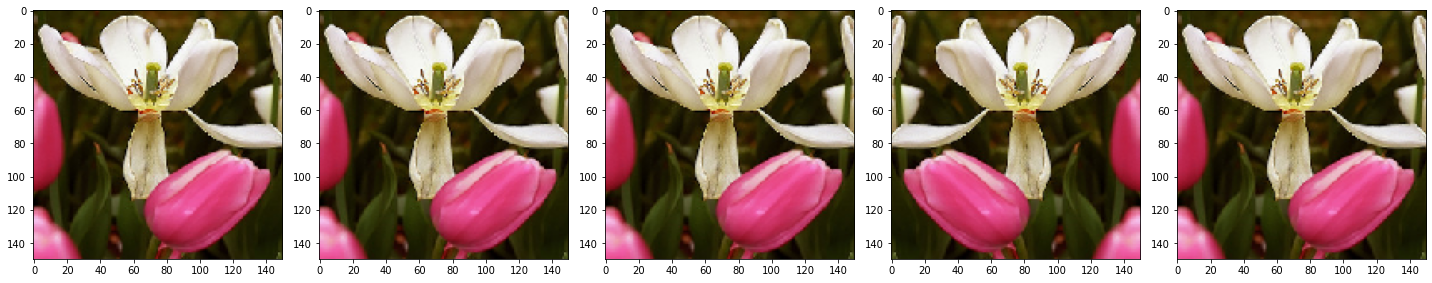

In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Rotation

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random 45 degree rotation. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images. 

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

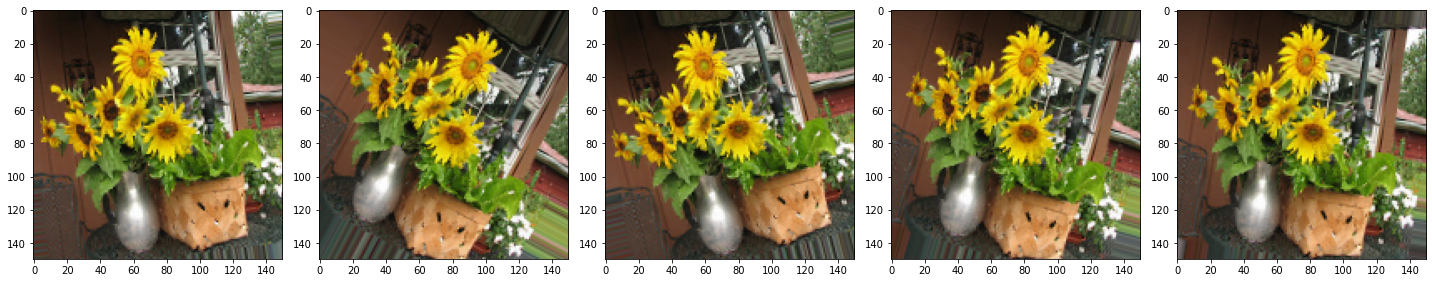

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Zoom

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random zoom of up to 50%. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images. 

In [14]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

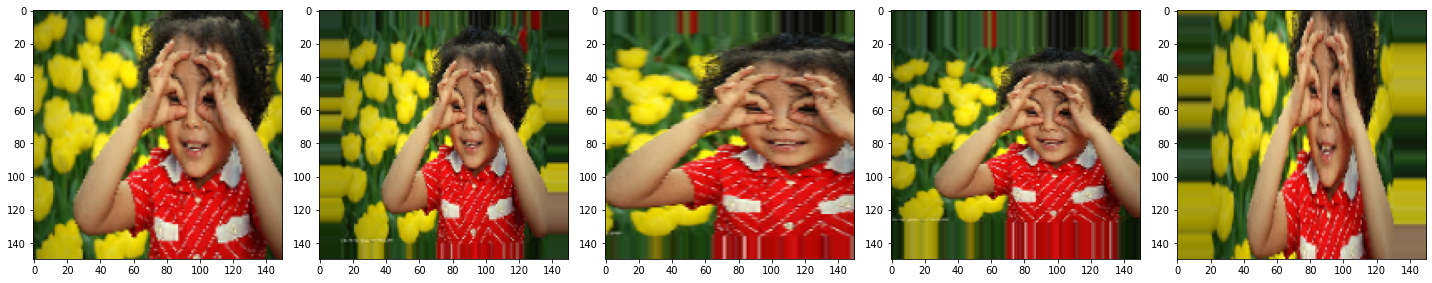

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Put It All Together

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, to shuffle the images, and to set the class mode to `sparse`.

In [16]:
image_gen_train = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=45,
                                     zoom_range=0.5,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     fill_mode='nearest')

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='sparse')

Found 2935 images belonging to 5 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

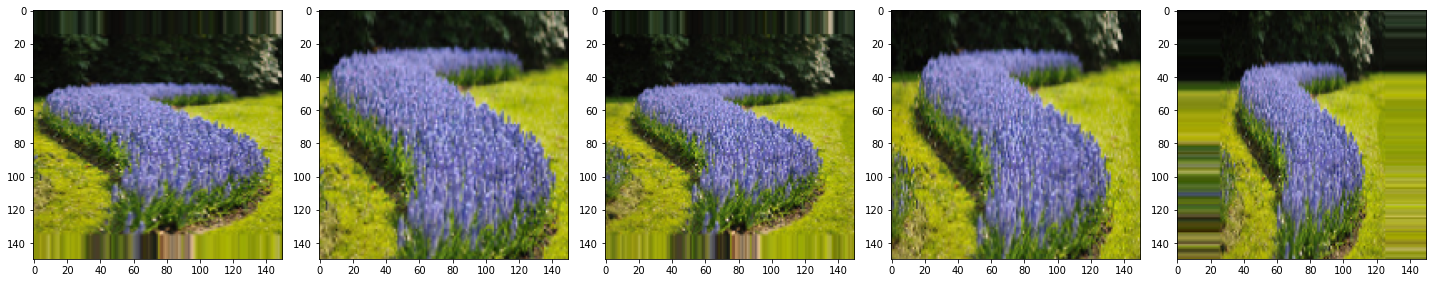

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Create a Data Generator for the Validation Set

Generally, we only apply data augmentation to our training examples. So, in the cell below, use ImageDataGenerator to create a transformation that only rescales the images by 255. Then use the `.flow_from_directory` method to apply the above transformation to the images in our validation set. Make sure you indicate the batch size, the path to the directory of the validation images, the target size for the images, and to set the class mode to `sparse`. Remember that it is not necessary to shuffle the images in the validation set. 

In [18]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


# TODO: Create the CNN

In the cell below, create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a `Conv2D` layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a `pool_size` of `(2, 2)`.

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the **softmax** activation function. All other layers should use a **relu** activation function. You should also add Dropout layers with a probability of 20%, where appropriate. 

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
])

# TODO: Compile the Model

In the cell below, compile your model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so make sure you also pass the metrics argument.

In [20]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        1

# TODO: Train the Model

In the cell below, train your model using the **fit_generator** function instead of the usual **fit** function. We have to use the `fit_generator` function because we are using the **ImageDataGenerator** class to generate batches of training and validation data for our model. Train the model for 80 epochs and make sure you use the proper parameters in the `fit_generator` function.

In [22]:
epochs = 80

print(train_data_gen.n)
print(val_data_gen.n)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

2935
735


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
30/30 [==============================] - 30s 731ms/step - loss: 2.7065 - accuracy: 0.1937 - val_loss: 1.5730 - val_accuracy: 0.2803
Epoch 2/80
30/30 [==============================] - 22s 726ms/step - loss: 1.5003 - accuracy: 0.2889 - val_loss: 1.5774 - val_accuracy: 0.3728
Epoch 3/80
30/30 [==============================] - 22s 723ms/step - loss: 1.3683 - accuracy: 0.4320 - val_loss: 1.2727 - val_accuracy: 0.4585
Epoch 4/80
30/30 [==============================] - 22s 723ms/step - loss: 1.1939 - accuracy: 0.4931 - val_loss: 1.2026 - val_accuracy: 0.4803
Epoch 5/80
30/30 [==============================] - 22s 736ms/step - loss: 1.1277 - accuracy: 0.5250 - val_loss: 1.1375 - val_accuracy: 0.5429
Epoch 6/80
30/30 [==============================] - 22s 733ms/step - loss: 1.0719 - accuracy: 0.5706 - val_loss: 1.1118 - val_accuracy: 0.5224
Epoch 7/80
30/30 [==============================] - 22s 727ms/step - loss: 1.0278 - accuracy: 0.5924 - val_loss: 1.0817 - val_accuracy: 0.5782

# TODO: Plot Training and Validation Graphs.

In the cell below, plot the training and validation accuracy/loss graphs.

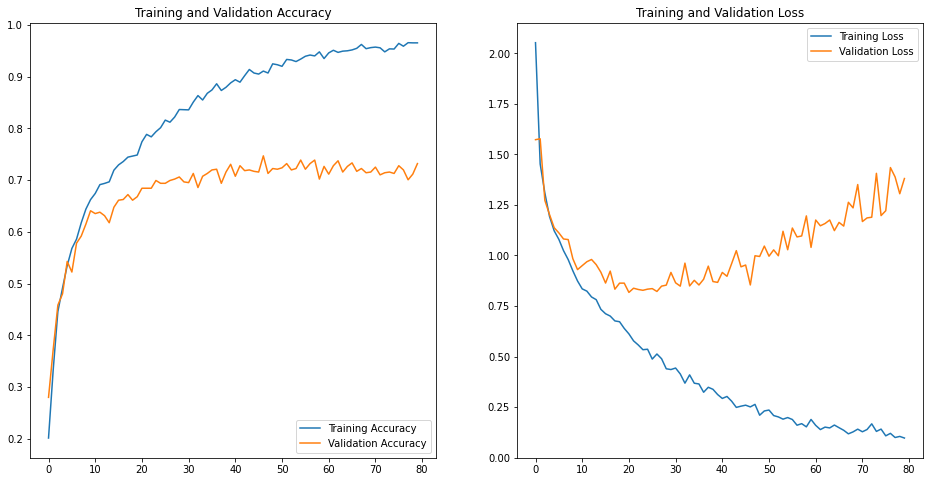

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# TODO: Experiment with Different Parameters

So far you've created a CNN with 3 convolutional layers and followed by a fully connected layer with 512 units. In the cells below create a new CNN with a different architecture. Feel free to experiment by changing as many parameters as you like. For example, you can add more convolutional layers, or more fully connected layers. You can also experiment with different filter sizes in your convolutional layers, different number of units in your fully connected layers, different dropout rates, etc... You can also experiment by performing image augmentation with more image transformations that we have seen so far. Take a look at the [ImageDataGenerator Documentation](https://keras.io/preprocessing/image/) to see a full list of all the available image transformations. For example, you can add shear transformations, or you can vary the brightness of the images, etc... Experiment as much as you can and compare the accuracy of your various models. Which parameters give you the best result?